# SDO/AIA and Solar Orbiter/EUI alignment tutorial

In this tutorial, we will

- Retrive HRI EUV 174 EUI data and AIA data using [Fido](https://docs.sunpy.org/en/stable/generated/api/sunpy.net.Fido.html#sunpy.net.Fido)
- Correct for 'jitter' in EUI images
- align aia/eui images in time (account for timing delay)
- use wcs to align in space
- for small scale, may need to apply additional correction

----

Before jumping in, we first need to import the necessary packages. The cell should have no issues running if your conda environment is setup correctly or if you're running this notebook externally via Binder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import astropy
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch

import sunpy
import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a

import astropy.units as u
from astropy.coordinates import SkyCoord

import skimage
import scipy

from tqdm import tqdm

# big plots!
plt.rcParams["figure.figsize"] = (10, 10)

---

First let's retrieve the data using SunPy's Fido! We'll be working with a short HRIEUV time series on March 5th 2022.

(have alternative for reading in FITS files to sunpy maps?)


In [2]:
# EUI
instrument = a.Instrument('EUI')

time = a.Time('2022-03-05 15:20:00', '2022-03-05 15:21:00')

level = a.Level(2)

product = a.soar.Product('eui-hrieuv174-image')

eui_result = Fido.search(instrument & time & level & product)

# print out the files found
print(eui_result)

Results from 1 Provider:

12 Results from the SOARClient:

Instrument     Data product    Level ... Detector Wavelength
                                     ...                    
---------- ------------------- ----- ... -------- ----------
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0




Let's download the EUI files we queried for

In [3]:
# fetch the data files
eui_files = Fido.fetch(eui_result)

# read the data files in as a sequence of SunPy maps
eui_seq = sunpy.map.Map(eui_files, sequence=True)

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

Now that we have our data as Sunpy maps, we can easily make a movie

2025-02-14 10:15:21 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-14 10:15:21 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


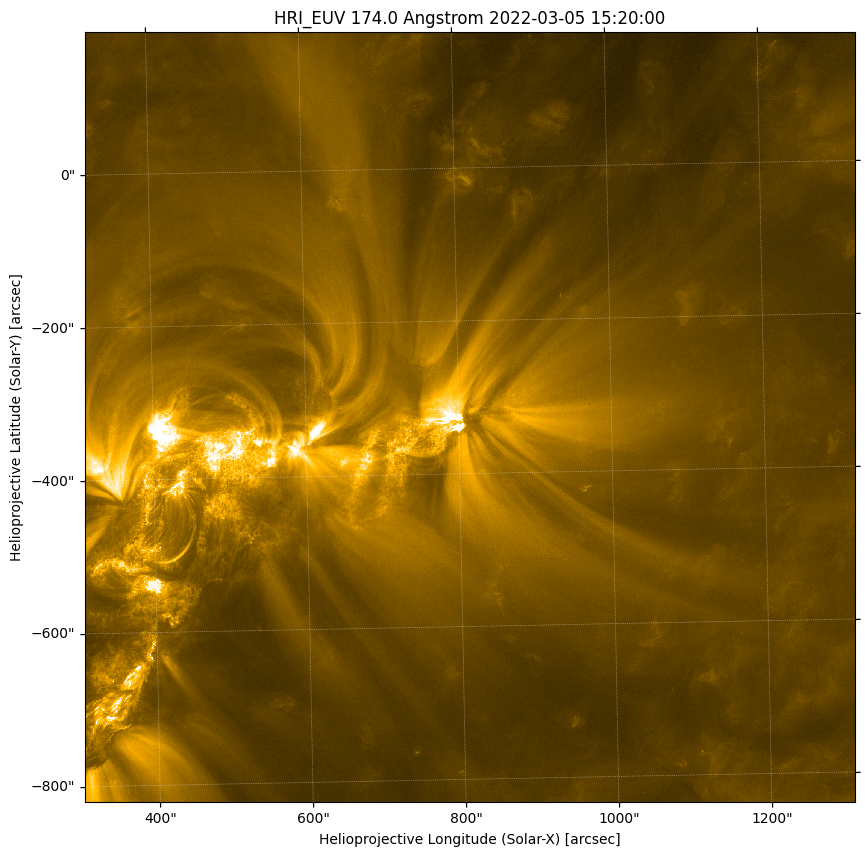

In [4]:
for each_map in eui_seq:

    # normalize each map the same way
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=10000, stretch=SqrtStretch())
    
plt.figure()
ani = eui_seq.plot()

# will save a gif 
ani.save('first_eui_animation.gif')

Now we have a movie of the EUI data we retrieved!
![SegmentLocal](first_eui_animation.gif "segment")

Let's zoom in!

In [5]:
submaps = []

for each_map in eui_seq:

    bl = [50,500] * u.pixel
    tr = [450,900] * u.pixel

    ## YOU CAN ALSO SPECIFY THE COORDINATES IN ARCSEC 
    # bl = SkyCoord(350*u.arcsec, -550*u.arcsec, frame=each_map.coordinate_frame)  # bottom left coordinate
    # tr = SkyCoord(500*u.arcsec, -400*u.arcsec, frame=each_map.coordinate_frame)  # top right coordinate

    submap = each_map.submap(bl, top_right=tr)
    submaps.append(submap)

eui_seq_submaps = sunpy.map.Map(submaps, sequence=True)

2025-02-14 10:15:36 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-14 10:15:36 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


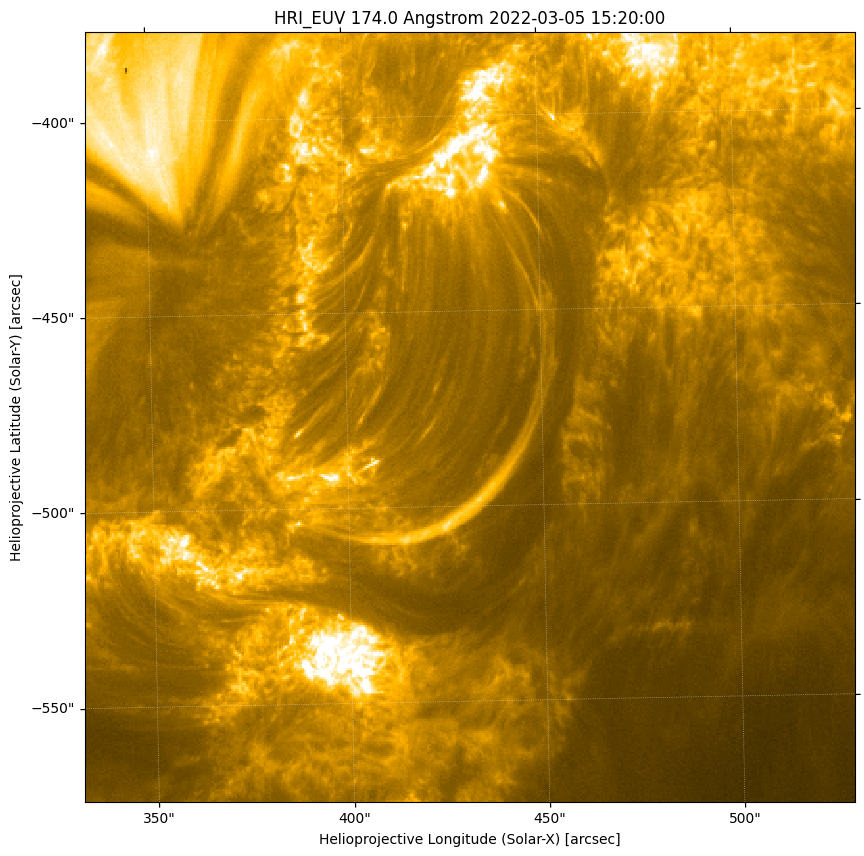

In [6]:
ani = eui_seq_submaps.plot()

ani.save('submap_eui_animation.gif')

![SegmentLocal](submap_eui_animation.gif "segment")

Hmmm looks like there's some jitter...

Let's do a few things the try and correct this. Starting with correcting for differential rotation. This won't have a huge affect on the time series we're working with (since it's so short) but plays a big role for other observations.

In [7]:
def correct_diff_rot(one_map, ref):
    """
    https://docs.sunpy.org/en/stable/generated/gallery/differential_rotation/reprojected_map.html

    Parameters
    ----------
    one_map: SunPy map object
        the map to derotate
    
    ref: SunPy map object
        the map to use as a reference for derotating

    Returns
    -------
    out_warp: SunPy map object
        `one_map` rotated to `ref`
    """
    in_time = one_map.date
    out_time = ref.date

    out_frame = sunpy.coordinates.Helioprojective(observer='earth',
                                                  obstime=out_time,
                                                  rsun=one_map.coordinate_frame.rsun)

    out_center = ref.center
    header = sunpy.map.make_fitswcs_header(one_map.data.shape,
                                           out_center,
                                           scale=u.Quantity(one_map.scale))
    out_wcs = astropy.wcs.WCS(header)

    with sunpy.coordinates.propagate_with_solar_surface():
        out_warp = one_map.reproject_to(out_wcs)

    return out_warp

In [8]:
rotated_maps = []

for one_map in tqdm(eui_seq_submaps[0:]): # skip first one that will be our reference

    new_map = correct_diff_rot(one_map, eui_seq_submaps[0])

    rotated_maps.append(new_map)

rotated_seq = sunpy.map.Map(rotated_maps, sequence=True)

2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode?it/s]
2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode6it/s]
2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode2it/s]
2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode3it/s]
2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode4it/s]
2025-02-14 10:16:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode5it/s]
2025-02-14 10:16:04 - reproject.common - INFO: Calling _reproject_full in non-dask mode2it/s]
2025-02-14 10:16:04 - reproject.common - INFO: Calling _reproject_full in non-dask mode3it/s]
2025-02-14 10:16:04 - reproject.common - INFO: Calling _reproject_full in non-dask mode7it/s]
2025-02-14 10:16:04 - reproject.common - INFO: Calling _reproject_full in non-dask mode6it/s]
2025-02-14 10:16:04 - reproject.common - INFO: Calling _repr

![SegmentLocal](derotated_eui_animation.gif "segment")

A note about this technique: it does not preserve the original time information in the headers. We'll have to access the original sequence of SunPy maps for the accurate times.

---

Still some jitter... this is from the instrument pointing and can't be corrected with techniques dervived from FITS file keywords. We'll have to apply a manual correction. Here we'll use cross correlation. I found that this works best on a small and relatively stable region.

(another method walked through here: https://github.com/SolarOrbiterWorkshop/solo8_tutorials/blob/main/EUI_tutorial/3_alignment_b.ipynb)

Let's try cross correlation on a small FOV:

TypeError: Invalid input, bottom_left must be of type SkyCoord or BaseCoordinateFrame.

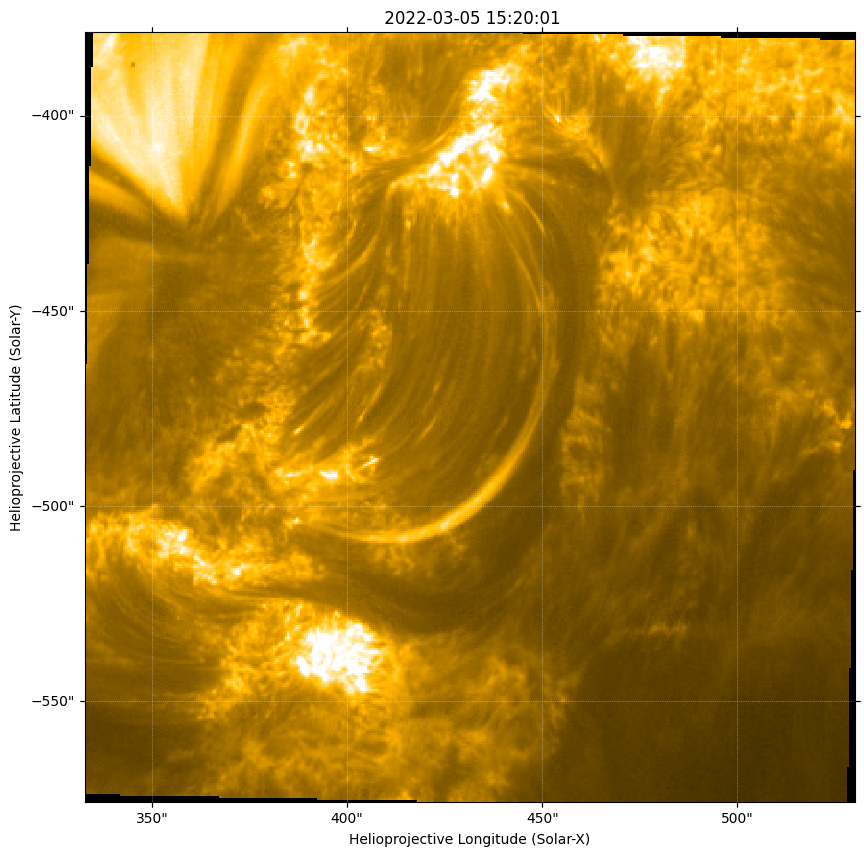

In [26]:
first_map = rotated_seq[0]

ax = fig.add_subplot(projection=first_map)
first_map.plot()

rectangle = [100*u.pixel, 100*u.pixel]

first_map.draw_quadrangle(
    rectangle,
    axes=ax,
    edgecolor="red",
    linestyle="--",
    linewidth=2,
)

plt.show()

In [13]:
shifts = []

for i in range(len(rotated_seq)): # on the derotated sequence!

    if i == 0: # using first image as reference, no shift
        shift = [0, 0]
        
    else:
        img1 = rotated_seq[i-1].data[250:350, 300:350]
        img2 = rotated_seq[i].data[250:350, 300:350]
    
        # sub pixel cross correlation
        shift, error, phasediff = skimage.registration.phase_cross_correlation(img1, # reference image
                                                                               img2, # moving image
                                                                               upsample_factor=100)
    shifts.append(shift)

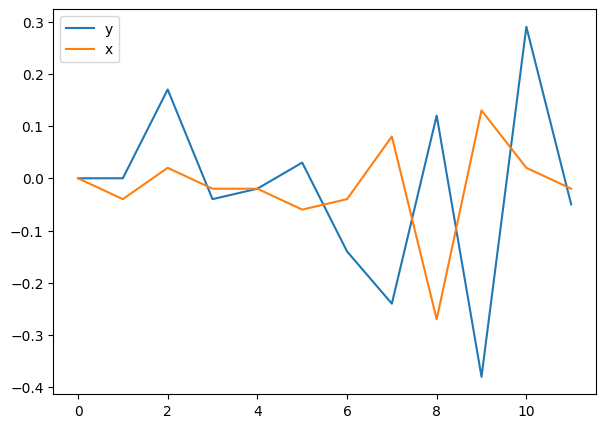

In [14]:
plt.figure(figsize=(7, 5))

plt.plot(shifts, label=['y','x'])
plt.legend()

In [15]:
y = []; x = []
for i in shifts:
    y.append(i[0]); x.append(i[1])

# sum the shifts
x_summed = [np.sum(x[:i]) for i in range(len(x))]
y_summed = [np.sum(y[:i]) for i in range(len(y))]

shifts_summed = []
for i in range(len(y_summed)):
        shifts_summed.append(np.array([y_summed[i], x_summed[i]]))

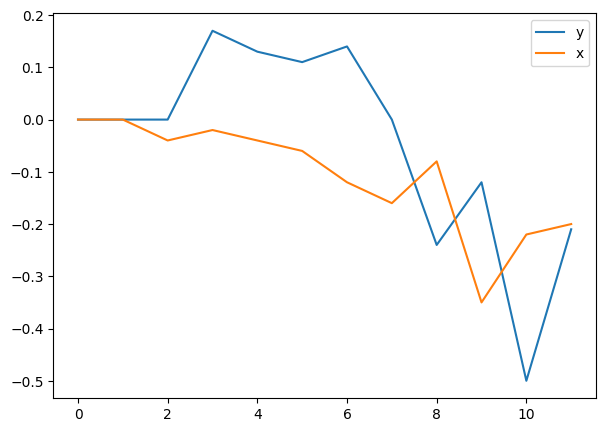

In [16]:
plt.figure(figsize=(7, 5))

plt.plot(shifts_summed, label=['y','x'])
plt.legend()

Now that we have unique shift value for each image in X and Y. Let's apply them:

In [17]:
def apply_shift(img, shift):
    """Perform sub-pixel image shift using fast fourier transforms
    (using scipy.ndimage's fourier_shift)
    
    Parameters
    ----------
    img: SunPy Map
        map to shift
        
    shift: list, size 2 (output of cross_correlate)
        shift[0] is shift to apply in y;
        shift[1] is shift to apply in x

    Returns
    -------
    shift_map: SunPy Map
        "img" shifted using values specified in "shift".
        Shifted bounds filled in with zeroes.
    """

    data = img.data
    
    data[np.isnan(data)] = 0

    shift_img = scipy.ndimage.fourier_shift(np.fft.fftn(data), shift)
    shift_img = np.fft.ifftn(shift_img).real # only keep real part

    # fill in parts of the shifted array with zeroes -- round up to integer
    y, x = shift
    if y > 0:
        shift_img[:int(y+1), :] = 0
    else:
        shift_img[int(y-1):, :] = 0

    if x > 0:
        shift_img[:, :int(x+1)] = 0
    else:
        shift_img[:, int(x-1):] = 0

    # recreate SunPy map
    shift_map = sunpy.map.Map((shift_img, img.meta))

    # color and normalize the same as before
    shift_map.plot_settings['cmap'] = 'solar orbiterhri_euv174'
    shift_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=10000, stretch=SqrtStretch())

    return shift_map

In [18]:
shifted_maps = []

for i, one_map in enumerate(rotated_seq):

    shifted_map = apply_shift(one_map, shifts_summed[i])
    
    shifted_maps.append(shifted_map)

shifted_seq = sunpy.map.Map(shifted_maps, sequence=True)

Let's play the zoom in movie again!

2025-02-14 10:18:05 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-14 10:18:05 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


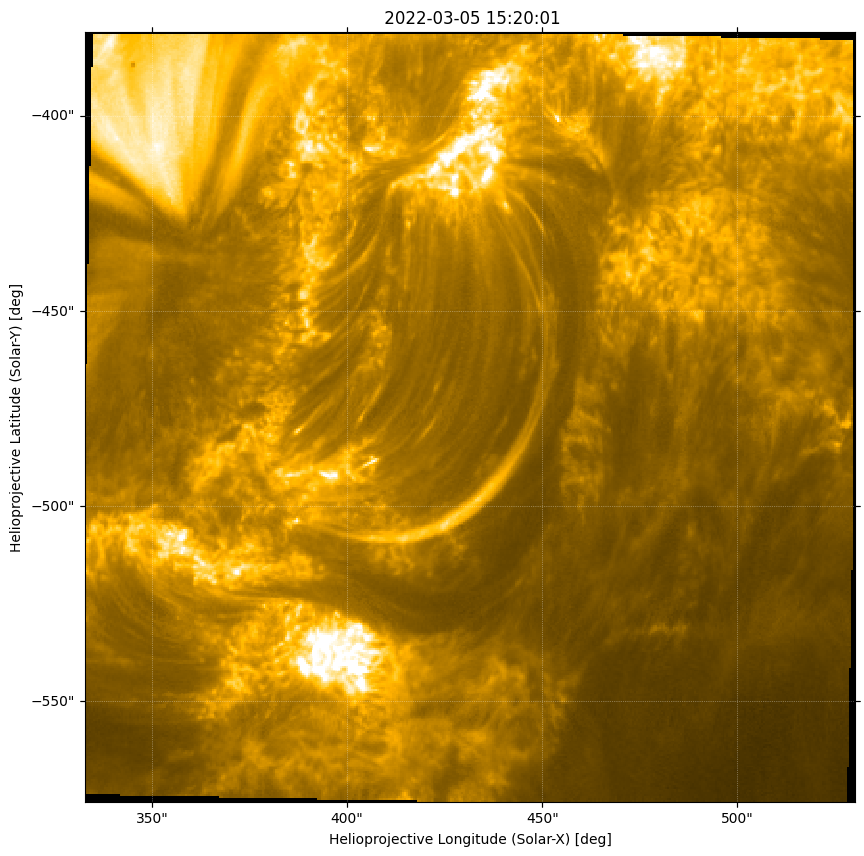

In [19]:
ani = shifted_seq.plot()

ani.save('shifted_eui_animation.gif')

![SegmentLocal](shifted_eui_animation.gif "segment")


Great! Now the EUI pointing is consistent with itself!

---

The WCS keywords in these FITS files give lots of useful information on these observations. 

A list of keywords can be found here: https://www.sidc.be/EUI/data/documents/SP-ROB-SOEUI-19001-DPDD_1.8.pdf

Keywords built in to SunPy can be accessed like this: `map.KEYWORD` where the list of supported keywords can be found here: https://docs.sunpy.org/en/stable/generated/api/sunpy.map.sources.EUIMap.html#sunpy.map.sources.EUIMap

If the keywords isn't nicely built into the EUI Sunpy map, they can accessed like so: `map.meta['KEYWORD']`


Let's try it out! Say we want to know the distance between Solar Orbiter/EUI and the Sun. This is built in to the SunPy map:

In [ ]:
eui_seq[0].dsun

If we want to know this value in terms of AU, we can do the conversion or simply use astropy!

In [ ]:
eui_seq[0].dsun.to(u.AU)

Another useful parameter is the angle from the Earth-Sun line... This isn't built into the SunPy map but ...

In [ ]:
eui_seq[0].meta['HGLT_OBS'] * u.deg # s/c Heliographic latitude (B0 angle) 

time delay

In [ ]:
(eui_seq[0].meta['EAR_TDEL'] * u.s).to(u.min)

There's an almost 4 minute time delay between when ... We'll need to take this into account when aligning with ...

---

Now let's bring in AIA data! Before downloading, we have to consider the fact that EUI is at a different distance from the Sun than SDO. We have to consider this timing offset when querying for AIA data

In [ ]:
### calculate timing offset ####

# start_time_aia
# end_time_aia

Now we have everything in terms of a 1 AU detection time -- we'll use these times to query for AIA data. For comparison purposes, we'll retrieve 171 $\AA$ data since it's a similar channel as HRIEUV's 174 $\AA$ channel

In [ ]:
# AIA

# include new timing

instrument = a.Instrument('AIA')
wavelength = a.Wavelength(171*u.angstrom)  # 171 angstrom filter

aia_result = Fido.search(instrument & time & wavelength)
print(aia_result)

In [ ]:
# fetch the data files
aia_files = Fido.fetch(aia_result)

# read the data files in as a sequence of SunPy maps
sunpy.map.Map(aia_files, sequence=True)

Now we have our AIA data as SunPy maps!

In [ ]:
#### movie

In order to align our AIA 171 \AA data with our EUI 174 \AA data, we'll use SunPy's reproject function:

In [ ]:
#### reproject

# show

This does a decent job! But let's say we're interested in small-scale features, let's zoom in...

In [ ]:
#### zoom in to small feature

### see that it isn't super well-aligned

On large scales, the built-in SunPy alignment looks good. But when we zoom in, we see that it's pretty off.

A way to go about fixing this is to use cross-correlation. .. not full fov ...

In [ ]:
### cross correlate

## apply shifts -- sunpy 'apply_shifts'

### zoom in

Now the alignment is even better!

---

Woohoo! We have AIA and EUI well aligned! But what if we wanted to throw IRIS data into the mix... we can retrieve IRIS data the same way we did for EUI and AIA.

In [ ]:
### pull iris data

In [ ]:
## movie

In [ ]:
### sunpy reproject to align

In [ ]:
### zoom in. well aligned?

... ensure that IRIS is well aligned we'll need to pull in AIA data at a similar channel and cross-correlate

In [ ]:
### pull aia 1600

### cross correlate w iris 1400

### zoom in -- better!

Now we have well-aligned data among 3 instruments!

----

HMI contours??